# Baseline Tax Model

(Insert nice description of problem...)


## Characteristic Equations

\begin{align*}
  z_t &= \rho_z z_{t-1} + \varepsilon_{t} \\
  r_t &= \alpha k_t^{\alpha - 1} (e^{z_t} l_t)^{1 - \alpha} \\
  w_t &= (1 - \alpha) (k_t / l_t)^{\alpha} e^{(1 - \alpha)z_t} \\
  T_t &= \tau (w_t l_t + (r_t - \delta) k_t) \\
  c_t &= (1 - \tau)(w_t l_t + (r_t - \delta) k_t) + k_t + T_t - k_{t+1} \\
  \chi l_t^{\theta} &= c_t^{-\gamma} w_t (1 - \tau) \\
  c_t^{-\gamma} &= \beta E_t [ c_{t+1}^{-\gamma} [(r_{t+1} - \delta)(1 - \tau) + 1]
\end{align*}

In [59]:
import dolo
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

In [2]:
fname = "baseline.yaml"
dolo.pcat(fname)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


## Define Model Type

In [8]:
mod = dolo.yaml_import(fname)
mod

error: 1, 1  : Linter Error: Uncaught Exception.


Model:
        ------
        name: "BaselineModel"
        type: "dtcc"
        file: "baseline.yaml

Equations:
----------

transition
 1  : 0.0250 : k(0) == ((1) - (delta)) * (k(-(1))) + i(-(1))
 2  : 0.0000 : z(0) == (rho_z) * (z(-(1))) + e_z(0)

arbitrage
 1  : -0.1789 : (1) - (((beta) * (((c(0)) / (c(1))) ** (gamma))) * (((rk(1)) - (delta)) * ((1) - (tau)) + 1))
 2  : -19.1162 : ((chi) * ((l(0)) ** (theta))) - ((((1) - (tau)) * (w(0))) * ((c(0)) ** (-(gamma))))

definitions
 1  : y = exp((1 - alpha)*z)*k**alpha*l**(1-alpha)
 2  : rk = alpha*y/k
 3  : w = (1-alpha)*y/l
 4  : T = tau * (w*l + (rk - delta)*k)
 5  : c = (1 - tau)*w*l + T - i

## Find Steady State

We had to put in a (very bad) guess of steady state when we initialized file, but now we can solve for the deterministic equilibrium and update this guess.

In [20]:
mod_ss = dolo.algos.steady_state.find_steady_state(mod)

kbar, zbar = mod_ss["states"]
ibar, lbar = mod_ss["controls"]

In [22]:
mod.set_calibration(k=kbar, z=zbar, i=ibar, l=lbar)
mod

Model:
        ------
        name: "BaselineModel"
        type: "dtcc"
        file: "baseline.yaml

Equations:
----------

transition
 1  : 0.0000 : k(0) == ((1) - (delta)) * (k(-(1))) + i(-(1))
 2  : 0.0000 : z(0) == (rho_z) * (z(-(1))) + e_z(0)

arbitrage
 1  : 0.0000 : (1) - (((beta) * (((c(0)) / (c(1))) ** (gamma))) * (((rk(1)) - (delta)) * ((1) - (tau)) + 1))
 2  : 0.0000 : ((chi) * ((l(0)) ** (theta))) - ((((1) - (tau)) * (w(0))) * ((c(0)) ** (-(gamma))))

definitions
 1  : y = exp((1 - alpha)*z)*k**alpha*l**(1-alpha)
 2  : rk = alpha*y/k
 3  : w = (1-alpha)*y/l
 4  : T = tau * (w*l + (rk - delta)*k)
 5  : c = (1 - tau)*w*l + T - i

Notice the residual on our equations is ~0! Success!

## Decision Rules

In [70]:
dr_perturb = dolo.perturbate(mod, solve_steady_state=True)

In [103]:
simuls = dolo.simulate(mod, dr_pertrub, N=5, T=150)

ksim = simuls[:, 0, 1]
zsim = simuls[:, 0, 2]
isim = simuls[:, 0, 3]
lsim = simuls[:, 0, 4]
ysim = simuls[:, 0, 5]

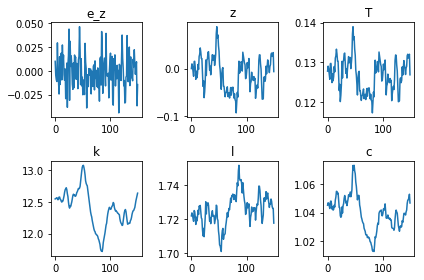

In [104]:
fig, ax = plt.subplots(2, 3)

ax[0, 0].plot(simuls[:, 0, 0])
ax[0, 0].set_title("e_z")

ax[0, 1].plot(simuls[:, 0, 2])
ax[0, 1].set_title("z")

ax[0, 2].plot(simuls[:, 0, 8])
ax[0, 2].set_title("T")

ax[1, 0].plot(simuls[:, 0, 1])
ax[1, 0].set_title("k")

ax[1, 1].plot(simuls[:, 0, 4])
ax[1, 1].set_title("l")

ax[1, 2].plot(simuls[:, 0, 9])
ax[1, 2].set_title("c")

fig.tight_layout()

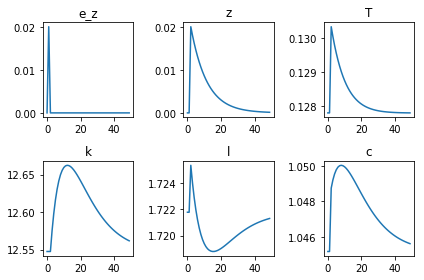

In [106]:
irf = dolo.response(mod, dr_perturb, 'e_z', T=50)

fig, ax = plt.subplots(2, 3)

ax[0, 0].plot(irf[:, 0])
ax[0, 0].set_title("e_z")

ax[0, 1].plot(irf[:, 2])
ax[0, 1].set_title("z")

ax[0, 2].plot(irf[:, 8])
ax[0, 2].set_title("T")

ax[1, 0].plot(irf[:, 1])
ax[1, 0].set_title("k")

ax[1, 1].plot(irf[:, 4])
ax[1, 1].set_title("l")

ax[1, 2].plot(irf[:, 9])
ax[1, 2].set_title("c")

fig.tight_layout()